In [4]:
import pandas as pd
import numpy as np
import mlp
from mlp.nn import *

In [5]:
data = np.load('tests_perfomance/datasets/cifar10.npz')
X, y = data['arr_0'], data['arr_1']
X.shape, y.shape

((50000, 32, 32, 3), (50000,))

In [55]:
import scipy as sp

In [57]:
import scipy.signal

In [74]:
img = X[0]
kernel = nn.layers[0].W[0, ...]
img.shape, kernel.shape

((32, 32, 3), (3, 3, 3))

In [87]:
c = sp.signal.fftconvolve(img, kernel, mode='valid')

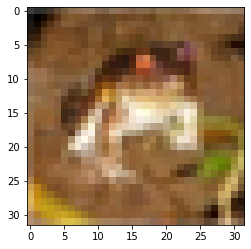

In [89]:
import matplotlib.pyplot as plt

plt.imshow(img);

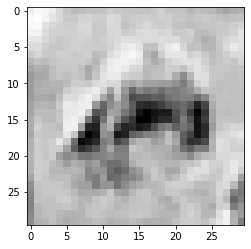

In [94]:
plt.imshow(c.squeeze(), cmap=plt.cm.Greys_r);

In [327]:
class Conv2D(Layer):
    def __init__(self, n_units, kernel_size, activation, stride=1, pad=0, trainable=True):
        self.n_units = n_units
        self.kernel_size = kernel_size
        self.kernel_height, self.kernel_width = self._kernel_size_map(kernel_size)
        self.stride = stride
        
        self.conv_mode = 'valid'
        self.pad = None
        self._pad_map(pad)
        
        self.activation = activation
    
        self.input_dim, self.output_dim = None, None
        
        self.trainable = trainable
        self.params = []
        
        self.last_input, self.last_output = None, None

    def forward_propagate(self, X, inference=False):
        
        n = len(X)
        
        Z = np.zeros((n, *self.output_dim))
        for i in range(n):
            for fi in range(self.n_units):
                img = X[i]
                filter = self.W[fi]
                Z[i, ..., fi] = sp.signal.fftconvolve(img, filter, mode=self.conv_mode)[::self.stride, ::self.stride, 0] + self.b[fi]
        
        if not inference:
            self.last_input = X
            self.last_output = Z

        A = self.activation.forward(Z)
        return A
    
    def backward_propagate(self, dA):
        print("last_output.shape=", self.last_output.shape, 'dA.T.shape=', dA.T.shape)
        dZ = self.activation.backward(self.last_output) * dA
        
        print(f"dZ.shape: {dZ.shape}")
        
        dA_prev = np.zeros_like(self.last_input, dtype=np.float64)            
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)

        # Pad A_prev and dA_prev
        A_prev_pad = self.zero_pad(dA_prev, self.pad)
        dA_prev_pad = self.zero_pad(dA_prev, self.pad)
        
        m, n_H, n_W, n_C = dZ.shape
        for i in range(m):                       # loop over the training examples

            # select ith training example from A_prev_pad and dA_prev_pad
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]
            for h in range(n_H):                   # loop over vertical axis of the output volume
                for w in range(n_W):               # loop over horizontal axis of the output volume
                    for c in range(n_C):           # loop over the channels of the output volume
                        
                        vert_start = h * self.stride
                        vert_end = vert_start + self.kernel_height
                        horiz_start = w * self.stride
                        horiz_end = horiz_start + self.kernel_width

                            
                        # Find the corners of the current "slice"

                            # Use the corners to define the slice from a_prev_pad
                        a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, ...]
                        # Update gradients for the window and the filter's parameters using the code formulas given above
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, ...] += self.W[c, ...] * dZ[i, h, w, c]
                        dW[c, ...] += a_slice * dZ[i, h, w, c]
                        db[c] += np.sum(dZ[i, h, w, c])

            # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
            if self.pad > 0:
                dA_prev[i, :, :, :] = da_prev_pad[self.pad:-self.pad, self.pad:-self.pad, :]
            else:
                dA_prev[i, ...] = da_prev_pad
        return dA_prev, dW, db
        
    
    def _initialize(self, in_dim):
        self.params.clear()
        print("In_dim:", in_dim)
        
        self.input_dim = in_dim
        
        h, w, c = in_dim
        
        h_new = int((h + 2 * self.pad - self.kernel_height) / self.stride) + 1
        w_new = int((w + 2 * self.pad - self.kernel_width) / self.stride) + 1
        c_new = self.n_units
        
        self.output_dim = (h_new, w_new, c_new)
        print("Out_dim:", self.output_dim)
        self.b = np.zeros((c_new, 1))
        self.W = np.random.randn(c_new, self.kernel_height, self.kernel_width, c) * 0.01
        print(self.b.shape, self.W.shape)
        self.params = [self.W, self.b]

    def _kernel_size_map(self, kernel_size):
        if type(kernel_size) is int:
            return kernel_size, kernel_size  # height, width
        elif len(kernel_size) == 2:
            return kernel_size
        else:
            raise ValueError(f"Kernel size is not understood: {kernel_size}")
    
    def _pad_map(self, pad):
        if type(pad) is int:
            self.pad = pad
            self.conv_type = 'valid'
        elif type(pad) is str and pad in ['valid', 'same']:
            self.pad = 0
            self.covn_type = pad
        else:
            raise ValueError(f"Padding is not understood: {pad}")
    
    def zero_pad(self, X, pad):
        return np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))
    
    @property
    def _n_params(self):
        return sum([p.size for p in self.params])
    
    def __repr__(self):
        return f"|{self.__class__.__name__}({self.kernel_height}, {self.kernel_width}, {self.activation})".ljust(20) + f"\t|{self._n_params}".rjust(20)


In [337]:
conv = Conv2D(30, 3, activation=Relu())
conv._initialize(X.shape[1:])

In_dim: (32, 32, 3)
Out_dim: (30, 30, 30)
(30, 1) (30, 3, 3, 3)


In [338]:
conv.W.shape

(30, 3, 3, 3)

In [339]:
res = conv.forward_propagate(X[:35])
res.shape

(35, 30, 30, 30)

In [340]:
dZ = np.random.randn(30, 30, 30, 1)

In [341]:
dA_prev, dW, db = conv.backward_propagate(res)

last_output.shape= (35, 30, 30, 30) dA.T.shape= (30, 30, 30, 35)
dZ.shape: (35, 30, 30, 30)


In [342]:
dW.shape

(30, 3, 3, 3)

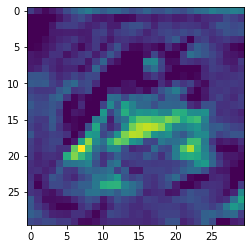

In [343]:
plt.imshow(res[0,...,5])

In [134]:
nn = NeuralNetwork('crossentropy', 'gd', verbose=True, verbose_step=1, random_state=42)
nn.add(Conv2D(3, 3, stride=2, activation=Relu()))
nn.add(Flatten())
nn.add(Dense(10, 'softmax'))

In [135]:
nn.compile(X.shape[1:])

In_dim: (32, 32, 3)
Out_dim: (15, 15, 3)
(3,) (3, 3, 3, 3)


In [136]:
nn.summary()

|Conv2D(3, 3, relu)                 	|84
Flatten
|Dense(675, 10, softmax)             	|	6760
Total number of parameters:		 6844
Total number of trainable params:	 6844
